In [29]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
from scipy.signal import welch
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, deepSkip, localSkip, localDeepSkip
# import parallel_euler as arch1
import torch
from torch import nn
import l96, glob, shutil
import config as cf

dynamical_system = 'L96'
root = f'../data/{dynamical_system}'
config = 'config_1_s' 
summary = ut.summary(dynamical_system)[config]
kwargs = {'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}

ut.latexify(summary)

['SkipRFM', 'DeepSkip', 'LocalSkip_2_2', 'LocalDeepRFM_2_2', 'LocalDeepSkip_1_4', 'LocalDeepSkip_2_2', 'LocalDeepSkipN_2_2']

\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|} \hline
\multicolumn{4}{|c|}{Model} &\multicolumn{5}{c|}{VPT} & \multicolumn{2}{c|}{}\\ \hline
architecture & $D_r$ & $B$ & model size & mean & std & median & min & max &$\beta$ & $\mathbb{E}[t_{\rm train}]$(s)\\ \hline\hline
\multirow{5}{*}{SkipRFM} & 512 & 1 & 41472 & 0.3 & 0.1 & 0.3 & 0.2 & 0.7 & 3.52e-09 & 1.6e-02\\ \cline{2-11}
 & 1024 & 1 & 82944 & 1.0 & 0.2 & 0.9 & 0.6 & 2.1 & 6.40e-09 & 2.4e-02\\ \cline{2-11}
 & 2048 & 1 & 165888 & 2.0 & 0.5 & 2.0 & 1.0 & 4.4 & 4.60e-08 & 6.6e-02\\ \cline{2-11}
 & 4096 & 1 & 331776 & 2.2 & 0.5 & 2.2 & 1.1 & 4.1 & 3.16e-07 & 2.3e-01\\ \cline{2-11}
 & \cellcolor{pink} 8192 & \cellcolor{pink} 1 & \cellcolor{pink} 663552 & \cellcolor{pink} 2.3 & \cellcolor{pink} 0.6 & \cellcolor{pink} 2.3 & \cellcolor{pink} 1.2 & \cellcolor{pink} 4.2 & \cellcolor{pink} 3.16e-07 & \cellcolor{pink} 1.0e+

**Find optimal localization**

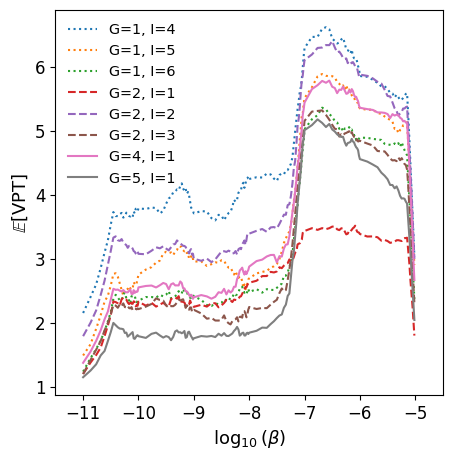

In [53]:
config = 'config_local'
architectures = ['LocalSkip']#, 'LocalDeepSkip']
GI = [[1, 4], [1, 5], [1, 6], [2, 1], [2, 2], [2, 3], [4, 1], [5, 1]]
localizations = [GI, GI]
D_rB = [[4096, 1]] * len(GI)
structures = [D_rB, D_rB]
markers = ['x', 'v']
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
smoothing_window = 15
for i, architecture in enumerate(architectures):
    for j, localization in enumerate(localizations[i]):
        G, I = localization
        D_r, B = structures[i][j]
        if G==2:
            linestyle = 'dashed'
        elif G==4 or G==5:
            linestyle = 'solid'
        else:
            linestyle = 'dotted'
        data = pd.read_csv(f'{root}/{config}/{architecture}_{G}_{I}/beta/beta_D_r-{D_r}_B-{B}.csv')
        x, y = data['beta'], data['tau_f_nmse_mean']
        y = ut.smooth(y, smoothing_window)
        ax.plot(np.log10(x), y, label=f'G={G}, I={I}', linestyle=linestyle)#, s=20, marker=markers[i])
ax.legend(frameon=False, fontsize=10.4)
ax.set_xlabel(r'$\log_{10}(\beta)$', fontsize=13)
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlim((-11.5, -4.5))
# fig.suptitle('L96-localization schemes')
plt.savefig(f'../data/plots/final/L96-localization-schemes.pdf', bbox_inches='tight', dpi=300)

**Violin plot of VPT**

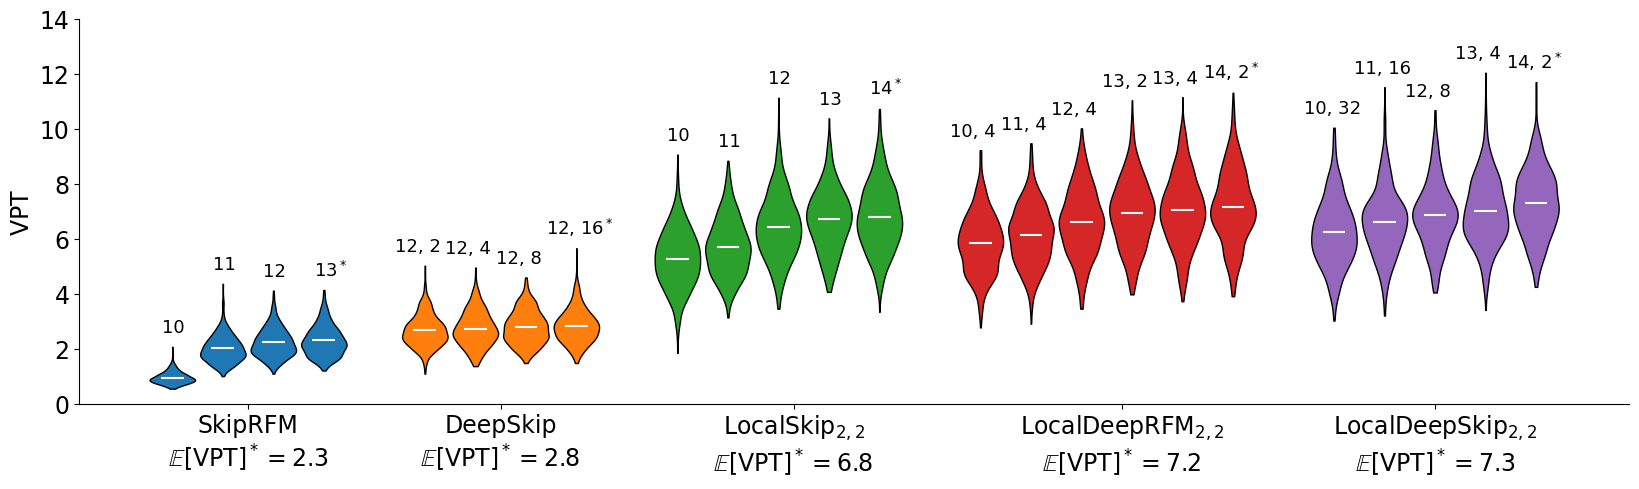

In [2]:
config = 'config_1_s'
architectures = {'config_1_s':['SkipRFM', 'DeepSkip', 'LocalSkip_2_2', 'LocalDeepRFM_2_2', 'LocalDeepSkip_2_2', 'LocalDeepSkipN_2_2'][:-1]}
clrs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = {'config_1_s': clrs}
x_pos = {'config_0':[2, 10], 'config_1_s':[1.5, 6.5, 12.3, 18.8, 25], 'config_0_s':[2, 10]}
x_labels = ['SkipRFM', 'DeepSkip', r'LocalSkip$_{2,2}$', r'LocalDeepRFM$_{2,2}$', r'LocalDeepSkip$_{2,2}$', r'LDSN_$_{2,2}$'][:-1]
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
smoothing_window = 5
m, n = 0, 0
params = []
best = []
vpts = []
cs = []
positions = []
summary = ut.summary(dynamical_system)[config]
for i, architecture in enumerate(architectures[config]):
    df_data = {'#params': [], 'vpt': []}
    subfolders = [x for x in glob.glob(f'{root}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv')]
    sf = [x for x in subfolders if 'LocalDeepSkip' in x]
    subfolders = [x for x in subfolders if 'LocalDeepSkip' not in x]
    sf = [x for x in sf if (ut.get_arch(x)[2:4] in [[1024, 32], [2048, 16], [4096, 8], [8192, 4], [16384, 2]])]
    subfolders += sf
    subfolders = [x for x in subfolders if "512" not in x]
    subfolders = [x for x in subfolders if ("DeepSkip/D_r-4096_B-1" not in x) or ("DeepSkip/D_r-4096_B-16" in x)]
    sizes = [[x[2], x[3]] for x in list(map(ut.get_arch, subfolders))]
    subfolders = [x for _, x in sorted(zip(sizes, subfolders))]
    n += len(subfolders)-1 
    best += [np.array(list(summary[architecture].values()))[:, 0].max()]
    for subfolder in subfolders:
        if not 'beta' in subfolder:
            arch = ut.get_arch(subfolder)
            if arch[2] == 11586 or arch[0].endswith('N_2_2'):
                continue
            # print(arch)
            data = pd.read_csv(f'{subfolder}/batch_data.csv')
            vpt = data['tau_f_nmse']
            vpts.append(vpt)
            p = np.log10(arch[-1])
            df_data['#params'] += [m] * len(vpt)
            df_data['vpt'] += vpt.to_list()
            params += [p]
            if architecture.startswith("LocalSkip") or architecture == "SkipRFM":
                text = r"{}".format(int(np.log2(arch[2])))
            else:
                text = r"{}, {}".format(int(np.log2(arch[2])), arch[3])
            if vpt.mean() == best[-1]:
                text += r'$^*$'
            if "Deep" not in arch[0]:
                ax.text(m+0.8-1, vpt.max()+0.5, text, fontsize=13)
            else:
                ax.text(m+0.4-1, vpt.max()+0.5, text, fontsize=13)
            positions += [m]
            m += 1
            cs.append(colors[config][i])
    df = pd.DataFrame(df_data)
    m += 1
    
    # sns.violinplot(data=df, x="#params", y="vpt", ax=ax)#  legend=False, split=True, hue_order=[0, 1])  

violin_parts = ax.violinplot(vpts,  positions=positions, showextrema=False, showmeans=True, side="both", widths=0.9)#"silverman")
for k, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(cs[k])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
violin_parts['cmeans'].set_color('white')

ax.set_xticks(x_pos[config], labels=[x_labels[i] + '\n' + r'$\mathbb{E}[\rm VPT]^*=$' + f'{best[i]:.1f}' for i in range(len(architectures[config]))])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'')
ax.set_ylabel(r'${\rm VPT}$', fontsize=17)
ax.set_ylim((0, 14))
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
plt.savefig(f'../data/plots/final/{dynamical_system}-{config}-vpt-violin.pdf', bbox_inches='tight', dpi=300)

**Climate Plot**

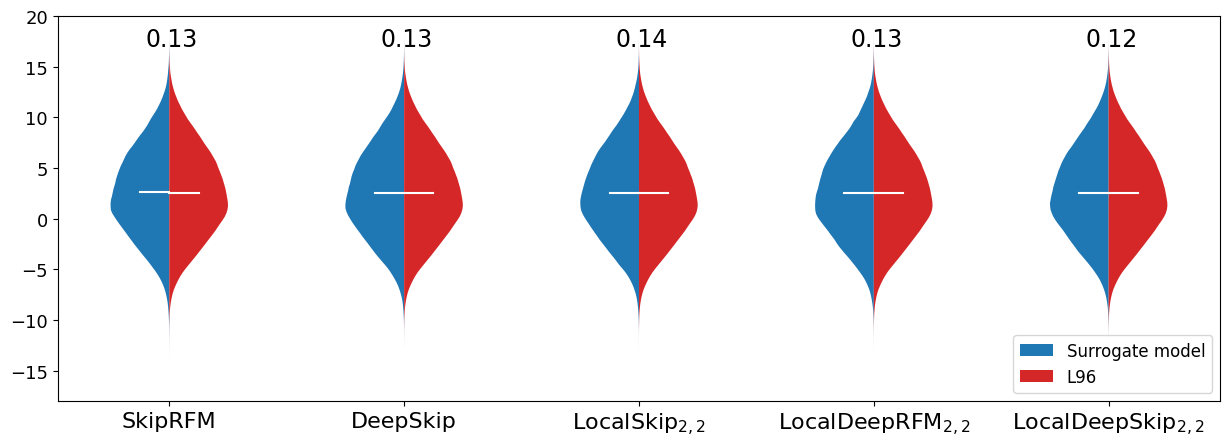

In [66]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
archs = ['SkipRFM', 'DeepSkip', 'LocalSkip', 'LocalDeepRFM', 'LocalDeepSkip']
archs_ = ['SkipRFM', 'DeepSkip', 'LocalSkip_2_2', 'LocalDeepRFM_2_2', 'LocalDeepSkip_2_2']
x_labels = ['SkipRFM', 'DeepSkip', r'LocalSkip$_{2,2}$', r'LocalDeepRFM$_{2,2}$', r'LocalDeepSkip$_{2,2}$', r'LDSN_$_{2,2}$'][:-1]
x_pos = [0, 1, 2, 3, 4]
tops = [r'$x_{20}$']
folders = [f'{root}/config_1_s/attractor' for arch in archs]
reconstruction = [np.load(f'{folders[i]}/{archs[i]}/attractor.npy').flatten() for i in range(5)]
original = [np.load(f'{folders[i]}/train.npy')[:reconstruction[i].shape[0]].flatten() for i in range(5)]
w2_data = pd.read_csv(f'{root}/{dynamical_system}-w2-flat.csv')
for i, arch in enumerate(archs):
    vp_left = ax.violinplot(reconstruction[i], positions=[i], showextrema=False, showmeans=True, side="low")
    vp_right = ax.violinplot(original[i], positions=[i], showextrema=False, showmeans=True, side="high")
    for vp in [vp_left, vp_right]:
        # vp['cmeans'].set_colors('white')
        for k, pc in enumerate(vp['bodies']):
            pc.set_alpha(1.0)
            if vp==vp_left:
                pc.set_facecolor(clrs[0])
                vp['cmeans'].set_colors('white')
            else:
                pc.set_facecolor(clrs[3])
                vp['cmeans'].set_colors('white')
    top = np.max([reconstruction[i].max(), original[i].max()])
    w2 = w2_data[w2_data['architecture']==archs_[i]].iloc[0]["w2"]**(0.5)
    idx1 = torch.randperm(len(original[i]))[:100000].numpy()
    idx2 = torch.randperm(len(reconstruction[i]))[:100000].numpy()
    ax.text(i-0.1, 17,  f'{w2:.2f}', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_ylim((-18, 20))
ax.legend([vp_left['bodies'][0], vp_right['bodies'][0]], ["Surrogate model", "L96"], loc='lower right', fontsize=12)
ax.set_xticks(x_pos, labels=x_labels, fontsize=16)
plt.savefig(f'../data/plots/final/{dynamical_system}-climate.pdf', bbox_inches='tight', dpi=300)

**Effect of depth**

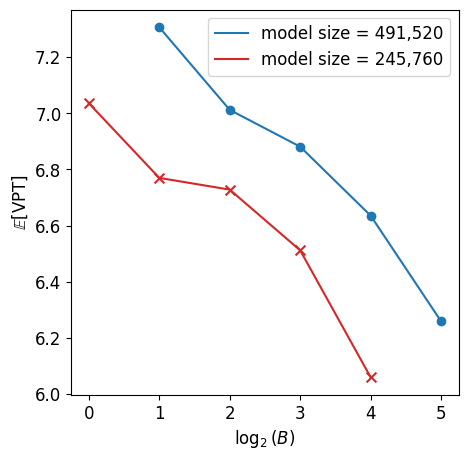

In [68]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
DrBs1 = [(16384, 2), (8192, 4), (4096, 8), (2048, 16), (1024, 32)]
DrBs2 = [(16384, 1), (8192, 2), (4096, 4), (2048, 8), (1024, 16)]
data_folders1 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs1]
data_folders2 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs2]

filename = '../data/plots/final/L96-depth.pdf'

x, y = [], []
for i, folder in enumerate(data_folders1):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs1[i][1]))
    y.append(data['tau_f_nmse'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[0])
ax.plot(x, y, c=clrs[0], label='model size = 491,520')

x, y = [], []
for i, folder in enumerate(data_folders2):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs2[i][1]))
    y.append(data['tau_f_nmse'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[3], marker='x', s=50)
ax.plot(x, y, c=clrs[3], label='model size = 245,760')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\log_2(B)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$', fontsize=12)
plt.savefig(filename, bbox_inches="tight", dpi=300)

**Training time**

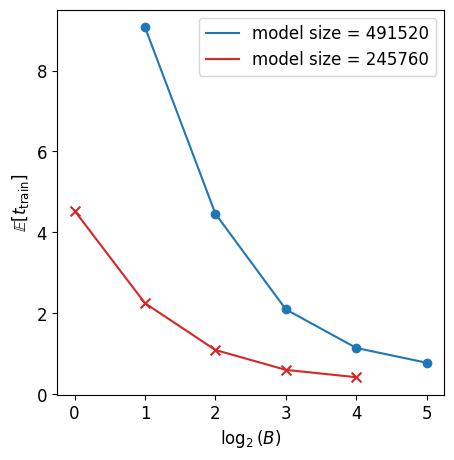

In [56]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
DrBs1 = [(16384, 2), (8192, 4), (4096, 8), (2048, 16), (1024, 32)]
DrBs2 = [(16384, 1), (8192, 2), (4096, 4), (2048, 8), (1024, 16)]
data_folders1 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs1]
data_folders2 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs2]

filename = '../data/plots/final/L96-time.pdf'

x, y = [], []
for i, folder in enumerate(data_folders1):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs1[i][1]))
    y.append(data['train_time'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[0])
ax.plot(x, y, c=clrs[0], label='model size = 491520')

x, y = [], []
for i, folder in enumerate(data_folders2):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs2[i][1]))
    y.append(data['train_time'].mean())
    ax.scatter(x[-1], y[-1], c=clrs[3], marker='x', s=50)
ax.plot(x, y, c=clrs[3], label='model size = 245760')
ax.legend(fontsize=12)
ax.set_xlabel(r'$\log_2(B)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_ylabel(r'$\mathbb{E}[t_{\rm train}]$', fontsize=12)
plt.savefig(filename, bbox_inches="tight", dpi=300)

**Runtime and model size**

['SkipRFM', 40, 4096, 1, 331776]
['SkipRFM', 40, 8192, 1, 663552]
['SkipRFM', 40, 1024, 1, 82944]
['SkipRFM', 40, 512, 1, 41472]
['SkipRFM', 40, 2048, 1, 165888]
['DeepSkip', 40, 4096, 8, 3964928]
['DeepSkip', 40, 4096, 1, 495616]
['DeepSkip', 40, 4096, 16, 7929856]
['DeepSkip', 40, 4096, 4, 1982464]
['DeepSkip', 40, 4096, 2, 991232]
['LocalSkip_2_2', 40, 4096, 1, 2, 2, 53248]
['LocalSkip_2_2', 40, 8192, 1, 2, 2, 106496]
['LocalSkip_2_2', 40, 1024, 1, 2, 2, 13312]
['LocalSkip_2_2', 40, 512, 1, 2, 2, 6656]
['LocalSkip_2_2', 40, 2048, 1, 2, 2, 26624]
['LocalSkip_2_2', 40, 16384, 1, 2, 2, 212992]
['LocalDeepSkip_2_2', 40, 16384, 4, 2, 2, 983040]
['LocalDeepSkip_2_2', 40, 2048, 2, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 1024, 2, 2, 2, 30720]
['LocalDeepSkip_2_2', 40, 4096, 8, 2, 2, 491520]
['LocalDeepSkip_2_2', 40, 2048, 4, 2, 2, 122880]
['LocalDeepSkip_2_2', 40, 1024, 16, 2, 2, 245760]
['LocalDeepSkip_2_2', 40, 4096, 1, 2, 2, 61440]
['LocalDeepSkip_2_2', 40, 16384, 2, 2, 2, 491520]
['Local

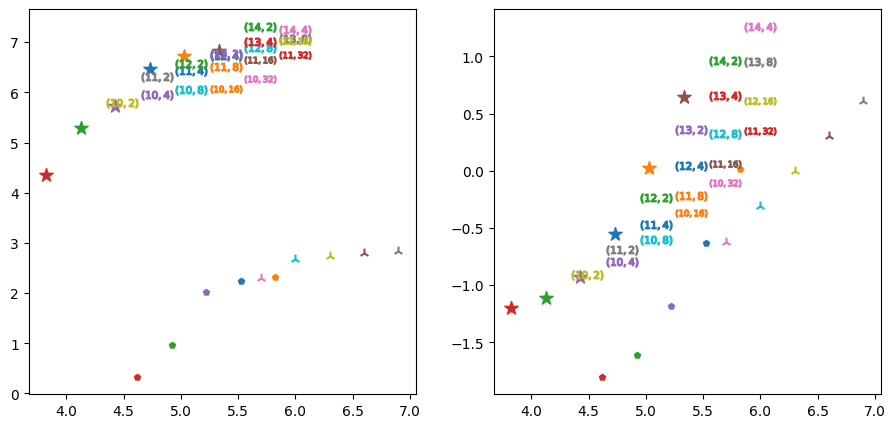

In [70]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
markers = {'SkipRFM': 'p', 'DeepSkip': '2', 'LocalSkip_2_2': '*', 'LocalDeepSkip_2_2': '.'}
s = {'SkipRFM': 20, 'DeepSkip': 50, 'LocalSkip_2_2': 80, 'LocalDeepSkip_2_2': 500}
for i, architecture in enumerate(architectures[config]):
    subfolders = [x for x in glob.glob(f'{folder}/{config}/{architecture}/*') if not 'beta' in x]
    subfolders = [x for x in subfolders if os.path.exists(f'{x}/batch_data.csv')]
    best += [max(summary[architecture].values())]
    for subfolder in subfolders:
        arch = ut.get_arch(subfolder)
        data = pd.read_csv(f'{subfolder}/batch_data.csv')
        vpt = data['tau_f_nmse']
        args = ut.get_arch(subfolder)
        print(args)
        if 'LocalDeepSkip' in architecture:
            if args[3] == 1:
                continue
            label = f'B={args[3]}'
            marker = fr"${(int(np.log2(args[2])), args[3])}$"
            if len(marker) > 9:
            
        else:
            label = None
            marker = markers[architecture]
            
        ax1.scatter(np.log10(arch[-1]), vpt.mean(), marker=marker, s=s[architecture])
        ax2.scatter(np.log10(arch[-1]), np.log10(data['train_time'].mean()), marker=marker, s=s[architecture])
# ax1.legend()

**Generate reconstructed attractor**

In [104]:
L0, L1, N = 0.4, 3.5, int(1e5)
train = np.load(f"{folder}/train.npy")
train = torch.tensor(train)[:, :N]

# SkipRFM
# arch, D_r, B = 'SkipRFM', 8192, 1
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = skipRFM.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

# DeepSkip
# arch, D_r, B = 'DeepSkip', 8192, 2
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = deepSkip.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

# LocalSkipRFM 
# arch, D_r, B, G, I = 'LocalSkip_2_2', 16384, 1, 2, 2
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = localSkip.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

# LocalDeepSkip
# arch, D_r, B, G, I = 'LocalDeepSkip_2_2', 16384, 2, 2, 2
# save_folder = f"{folder}/{config}/{arch}/D_r-{D_r}_B-{B}"
# beta_data = pd.read_csv(f"{folder}/{config}/{arch}/beta/beta_s.csv")
# beta = float(beta_data[(beta_data['D_r']==D_r) & (beta_data['B']==1)]['beta'].iloc[0])
# drf = localDeepSkip.DeepRF(D_r, B, L0, L1, train, beta, name=arch, save_folder=save_folder, G=G, I=I)
# drf.learn(train, 42)
# reconstructed_attractor = drf.multistep_forecast(train[:, 0], N)
# np.save(f"{save_folder}/attractor.npy", reconstructed_attractor)

**Plot PSD data**

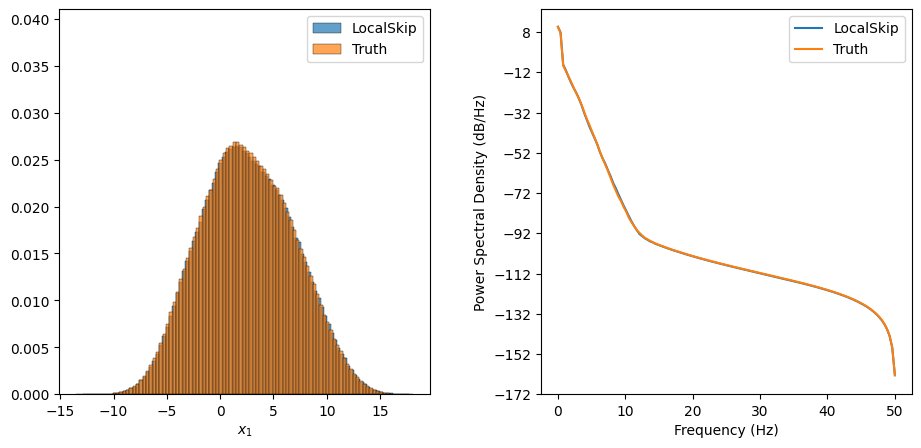

In [31]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
D_r, N = 4096, 100000
folders = [f"{folder}/{config}/SkipRFM/D_r-{D_r}_B-1", folder]# f"{folder}/{config}/DeepSkip/D_r-{D_r}_B-2",\
           #f"{folder}/{config}/LocalSkip_2_2/D_r-{D_r}_B-1", f"{folder}/{config}/LocalDeepSkip_2_2/D_r-{D_r}_B-2"]#, ]
folders = [f"{folder}/{config}/LocalSkip_2_2/D_r-{D_r}_B-1", folder]
for i, data_folder in enumerate(folders):
    filename = "attractor" if i < len(folders)-1 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
    label = "Truth" if i == len(folders)-1 else ut.get_arch(data_folder)[0]
    label = label.split('_')[0]
    # x, y = welch(attractor.mean(axis=0), 100)
    ax2.psd(attractor.mean(axis=0), Fs=100, label=label)
    sns.histplot(attractor.flatten(), ax=ax1, label=label, alpha=0.7, stat="probability", bins=100)
ax1.legend()
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('')
ax1.set_ylim((0, 0.041))
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('Frequency (Hz)')
fig.subplots_adjust(wspace=0.3)
plt.savefig('../data/plots/L96-climate.pdf', dpi=1200, bbox_inches="tight")

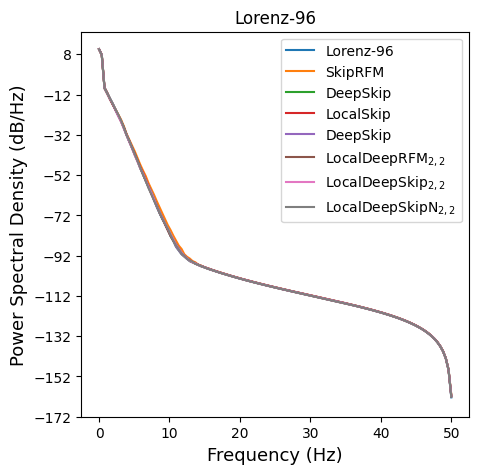

In [27]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(122)
D_r, N = 4096, 100000
folders = [f"{root}/{config}/attractor{a}" for a in ['', '/SkipRFM', '/DeepSkip', '/LocalSkip', '/DeepSkip', '/LocalDeepRFM',\
                                                     '/LocalDeepSkip', '/LocalDeepSkipN']]
labels = ['Lorenz-96', 'SkipRFM', 'DeepSkip', 'LocalSkip', 'DeepSkip', 'LocalDeepRFM'r'$_{2,2}$',\
                                                     'LocalDeepSkip'r'$_{2,2}$', 'LocalDeepSkipN'r'$_{2,2}$']
for i, data_folder in enumerate(folders):
    filename = "attractor" if i > 0 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
#     # x, y = welch(attractor.mean(axis=0), 100)
    ax1.psd(attractor.mean(axis=0), Fs=100, label=labels[i])
#     sns.histplot(attractor.flatten(), ax=ax1, label=label, alpha=0.7, stat="probability", bins=100)
# ax1.legend()
# ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel('Power Spectral Density (dB/Hz)', fontsize=13)

ax1.legend()
ax1.grid(False)
ax1.set_xlabel('Frequency (Hz)', fontsize=13)
ax1.set_title('Lorenz-96')
# fig.subplots_adjust(wspace=0.3)
plt.savefig('../data/plots/final/L96-psd.pdf', dpi=300, bbox_inches="tight")

<Axes: ylabel='tau_f_nmse'>

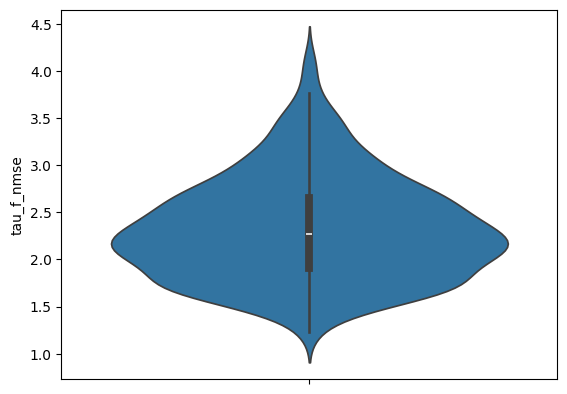

In [148]:
data = pd.read_csv(f'{folder}/{config}/SkipRFM/D_r-{2*D_r}_B-{1}/batch_data.csv')
sns.violinplot(data['tau_f_nmse'])

In [72]:
len(marker)

9

In [4]:
summary

{'LocalDeepSkip_1_4': {(16384, 2, 1, 4): 6.918778400000001},
 'LocalDeepSkip_2_2': {(1024, 1, 2, 2): 5.4977584,
  (1024, 2, 2, 2): 5.7808274,
  (2048, 1, 2, 2): 5.814605,
  (1024, 4, 2, 2): 5.9552996,
  (4096, 1, 2, 2): 6.0183148,
  (1024, 8, 2, 2): 6.0447376,
  (1024, 16, 2, 2): 6.0596288000000005,
  (8192, 1, 2, 2): 6.2302420000000005,
  (1024, 32, 2, 2): 6.2588894,
  (2048, 2, 2, 2): 6.3139596000000004,
  (2048, 4, 2, 2): 6.431681800000001,
  (2048, 8, 2, 2): 6.511722,
  (4096, 2, 2, 2): 6.557031200000001,
  (2048, 16, 2, 2): 6.635391600000001,
  (4096, 4, 2, 2): 6.7279622,
  (2048, 32, 2, 2): 6.737632400000001,
  (8192, 2, 2, 2): 6.769775600000001,
  (4096, 8, 2, 2): 6.8809602000000005,
  (8192, 4, 2, 2): 7.0121662,
  (4096, 16, 2, 2): 7.013482799999999,
  (16384, 1, 2, 2): 7.035955800000002,
  (8192, 8, 2, 2): 7.056295,
  (16384, 4, 2, 2): 7.235761200000001,
  (16384, 2, 2, 2): 7.306585200000001},
 'LocalDeepSkipN_2_2': {},
 'LocalSkip_2_2': {(512, 1, 2, 2): 4.3541324,
  (1024, 1,

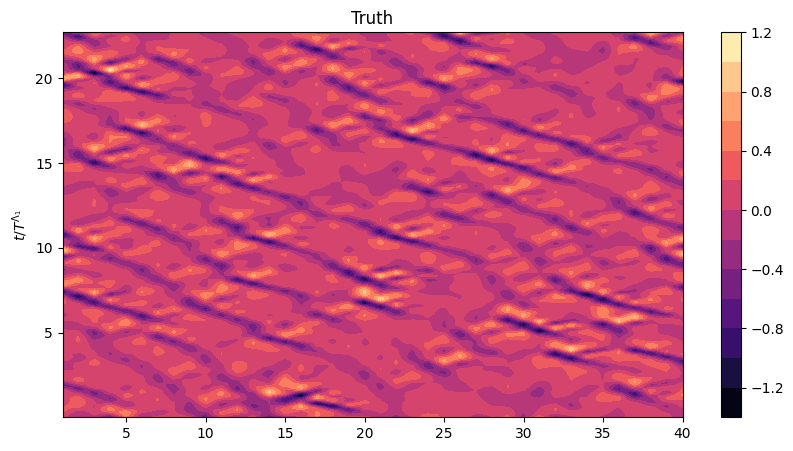

In [24]:
ut.waterfall(Uo[:, 1:1001]-Uo[:, :1000], **kwargs)

In [2]:
for a, b, c in ut.get_best_models(dynamical_system, 'config_1_s'):
    print(a, b, c)

LocalDeepSkip_1_4 (16384, 2, 1, 4) [6.918778400000001, 1.2535687244132625, 6.923500000000001, 3.6547, 11.0549, 6.399999999999999e-07, 9.441879753112794, 393216]
LocalDeepSkip_2_2 (16384, 2, 2, 2) [7.306585200000001, 1.2354542202451708, 7.241300000000001, 4.2676, 11.7132, 3.88e-07, 9.068817835330963, 491520]
LocalDeepSkipN_2_2 (16384, 2, 2, 2) [7.149410400000001, 1.2624219585442378, 7.0597, 3.7909, 10.7825, 3.88e-07, 9.519472737312316, 491520]
LocalSkip_2_2 (16384, 1, 2, 2) [6.8167192, 1.2275081722160037, 6.75325, 3.3596000000000004, 10.7371, 7.479999999999999e-07, 4.446301027774811, 212992]
SkipRFM (8192, 1) [2.321529, 0.5505663144000951, 2.27, 1.2258, 4.154100000000001, 3.16e-07, 1.0352710127830504, 663552]
DeepSkip (4096, 16) [2.8483959999999997, 0.6064618982029654, 2.8148, 1.4982000000000002, 5.675000000000001, 1.72e-07, 4.038104587078094, 7929856]
LocalDeepRFM_2_2 (16384, 2, 2, 2) [7.1840506, 1.3276863625322617, 7.11645, 3.9271, 11.3273, 3.88e-07, 9.496163321495056, 491520]


In [11]:
d  = {'a': [1, -3, 4], 'b': [0, 1, -1], 'c': [1, 5, 3]}
d =  {x:y for y, x in sorted(zip(d.values(), d.keys()))}

In [12]:
d

{'b': [0, 1, -1], 'a': [1, -3, 4], 'c': [1, 5, 3]}

In [16]:
sorted(zip(d.values(), d.keys()))[-1][-1]

'c'